<a href="https://colab.research.google.com/github/danielavela0227/AI_Agu-Dec-2024_BI_2002444/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project.- Training a Machine Learning model on medical images.**

* Student's name:

        Daniela Lizeth Vela Carrillo    2002444
        Mariana Salinas Dávila          1962270
        Valeria Rodríguez Morales       2000303
        Abel Antonio Ramírez Cavazos    1994382
        Daniela Ortega González         1999960
* Group: 002
* Class: Thursday, N4-N6

### **Load Libraries**

In [ ]:
import os
import zipfile
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
from google.colab import files

### **Load Data**

In [ ]:
!pip install kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danielaortegagonzlez","key":"71be9ed178d7185265ab2ff1ef895cb3"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 94% 140M/149M [00:00<00:00, 172MB/s]
100% 149M/149M [00:00<00:00, 169MB/s]


In [ ]:
# Path to downloaded ZIP file
zip_file_path = '/content/brain-tumor-mri-dataset.zip'
extracted_folder_path = '/content/Dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

### **Data preprocessing**

In [ ]:
# Folder path to save processed images
rescaled_images_folder = '/content/Processed_Dataset'
os.makedirs(rescaled_images_folder, exist_ok=True)

In [ ]:
# Obtain the minimum resolution
min_width, min_height = float('inf'), float('inf')

# Loop through each image in the folder to fing the minimum resolution
for split_folder in ['Training', 'Testing']:
    split_path = os.path.join(extracted_folder_path, split_folder)
    for tumor_type in os.listdir(split_path):
        tumor_path = os.path.join(split_path, tumor_type)
        if os.path.isdir(tumor_path):
            for file in os.listdir(tumor_path):
                if file.endswith(('jpg', 'jpeg', 'png')):
                    image_path = os.path.join(tumor_path, file)
                    img = cv2.imread(image_path)
                    if img is not None:
                        height, width = img.shape[:2]
                        min_width = min(min_width, width)
                        min_height = min(min_height, height)

print(f'Minimum resolution found: {min_width}x{min_height}')

Minimum resolution found: 150x168


In [ ]:
# Process each image so that they all have the same minimum resolution
for split_folder in ['Training', 'Testing']:
    split_path = os.path.join(extracted_folder_path, split_folder)
    processed_split_path = os.path.join(rescaled_images_folder, split_folder)
    os.makedirs(processed_split_path, exist_ok=True)

    for tumor_type in os.listdir(split_path):
        tumor_path = os.path.join(split_path, tumor_type)
        processed_tumor_path = os.path.join(processed_split_path, tumor_type)
        os.makedirs(processed_tumor_path, exist_ok=True)

        if os.path.isdir(tumor_path):
            for file in os.listdir(tumor_path):
                if file.endswith(('jpg', 'jpeg', 'png')):
                    image_path = os.path.join(tumor_path, file)
                    img = cv2.imread(image_path)

                    if img is not None:
                        img_resized = cv2.resize(img, (min_width, min_height), interpolation=cv2.INTER_AREA)

                        save_path = os.path.join(processed_tumor_path, file)
                        cv2.imwrite(save_path, img_resized)

print(f"All images have been resized and saved in {rescaled_images_folder}")

All images have been resized and saved in /content/Processed_Dataset


In [ ]:
# Routes of the folders that contain de Training and Testing Images
train_dir = '/content/Processed_Dataset/Training'
test_dir = '/content/Processed_Dataset/Testing'

# Pre-processing parameters and images size
img_size = (150, 168)
batch_size = 32

# Preprocessing for the image generator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generator ofr training and testing
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Extract all images and labels from the training data
train_images, train_labels = [], []
for i in range(len(train_data)):
    images, labels = train_data[i]
    train_images.extend(images)
    train_labels.extend(labels)
    if (i + 1) * batch_size >= train_data.n:
        break

# Convert lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels).astype(int)

# Extract all images and tags from the test data generator
test_images, test_labels = [], []
for i in range(len(test_data)):
    images, labels = test_data[i]
    test_images.extend(images)
    test_labels.extend(labels)
    if (i + 1) * batch_size >= test_data.n:
        break

test_images = np.array(test_images)
test_labels = np.array(test_labels).astype(int)

# Data validation
print("train_images shape:", train_images.shape)
print("train_labels unique values:", np.unique(train_labels))
print("test_images shape:", test_images.shape)
print("test_labels unique values:", np.unique(test_labels))

train_images shape: (5712, 150, 168, 3)
train_labels unique values: [0 1 2 3]
test_images shape: (1311, 150, 168, 3)
test_labels unique values: [0 1 2 3]


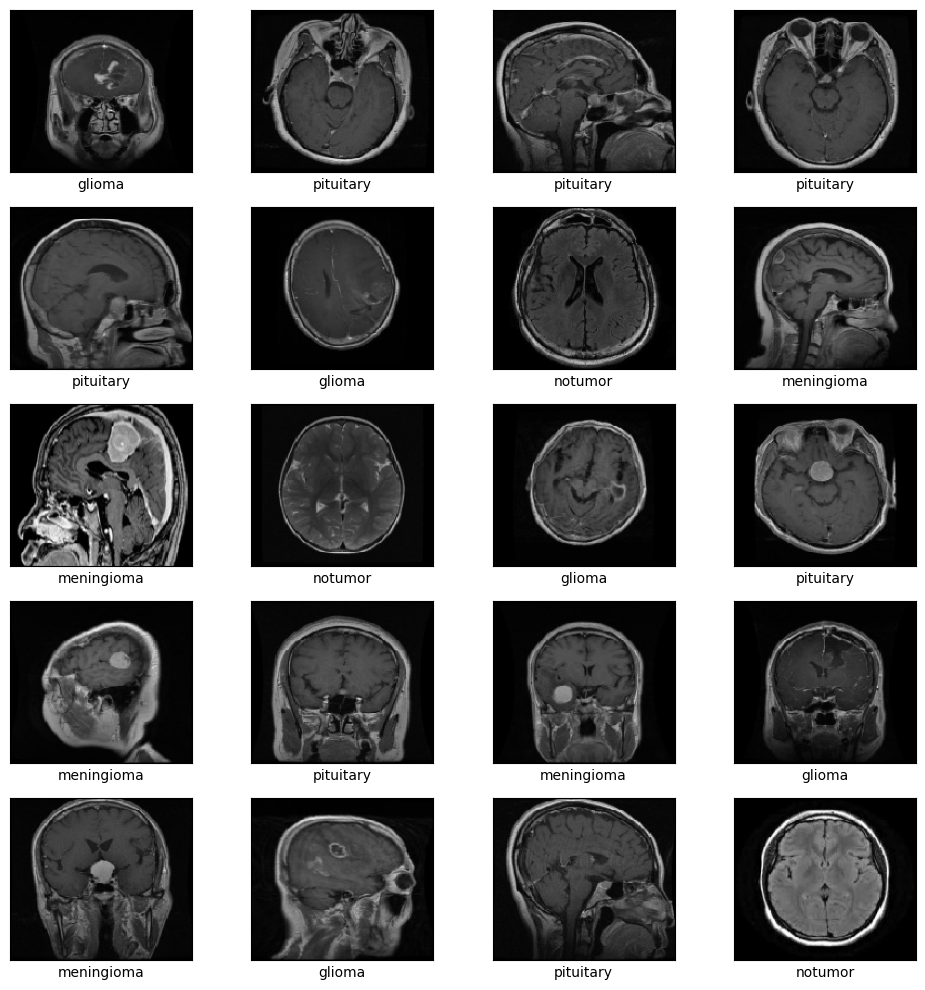

In [ ]:
# Show images and its labels
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(list(train_data.class_indices.keys())[train_labels[i]])
plt.tight_layout()
plt.show()

### **Model Selection and Training**

In [ ]:
# Structure of the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 168, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(train_images, train_labels, epochs=10, batch_size=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 442s 767ms/step - accuracy: 0.9216 - loss: 0.2178 - val_accuracy: 0.7757 - val_loss: 0.7055
Epoch 2/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 455s 791ms/step - accuracy: 0.9259 - loss: 0.2023 - val_accuracy: 0.8482 - val_loss: 0.4335
Epoch 3/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 482s 757ms/step - accuracy: 0.9426 - loss: 0.1607 - val_accuracy: 0.7826 - val_loss: 0.5886
Epoch 4/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 431s 754ms/step - accuracy: 0.9361 - loss: 0.1673 - val_accuracy: 0.8673 - val_loss: 0.3522
Epoch 5/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 441s 752ms/step - accuracy: 0.9446 - loss: 0.1551 - val_accuracy: 0.9214 - val_loss: 0.2095
Epoch 6/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 444s 755ms/step - accuracy: 0.9524 - loss: 0.1261 - val_accuracy: 0.8063 - val_loss: 0.5301
Epoch 7/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 442s 755ms/step - accuracy: 0.9609 - loss: 0.1109 - val_accuracy: 0.8535 - val_loss: 0.4386
Epoch 8/10
572/572 ━━━━━━━━━━━━━━━━━━━━ 442s 754ms/step - accuracy: 0.9657 -

### **Model Testing**

41/41 - 28s - 685ms/step - accuracy: 0.9100 - loss: 0.2669


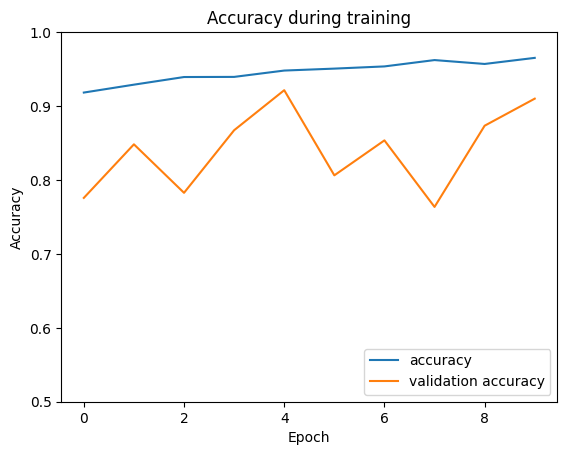

In [ ]:
# Graph the accuracy and loss during training
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


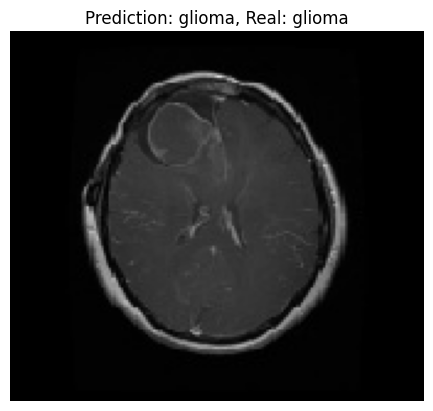

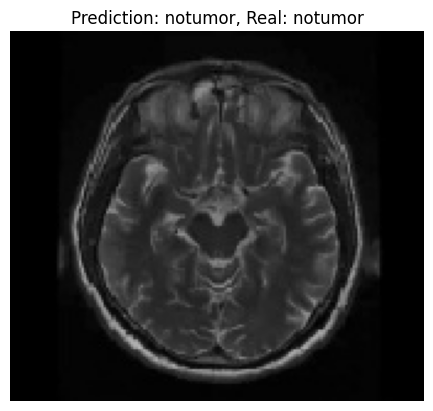

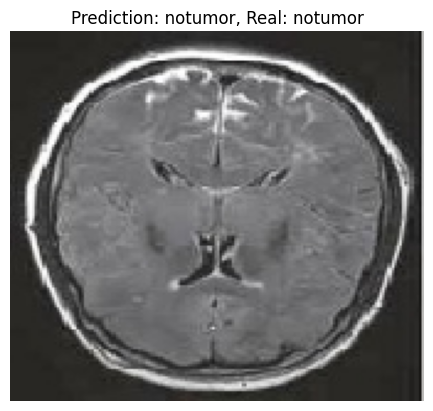

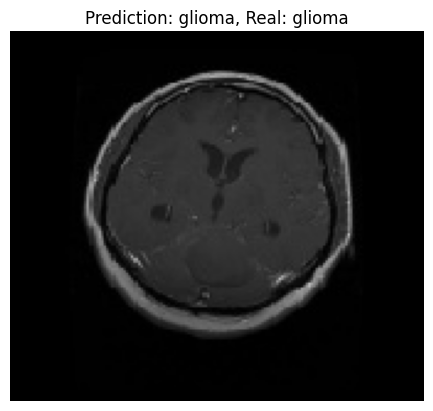

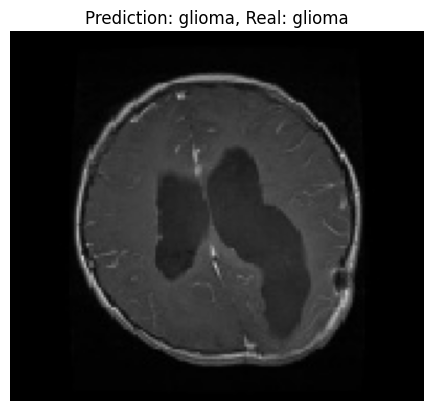

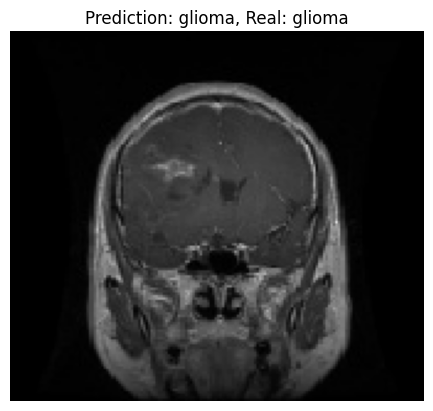

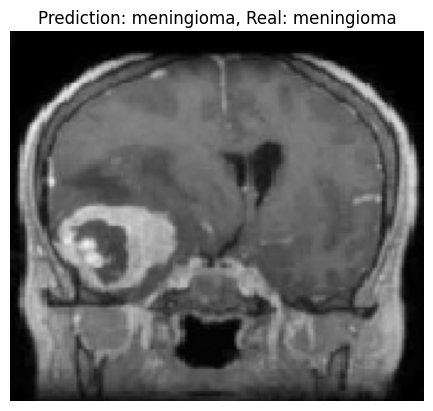

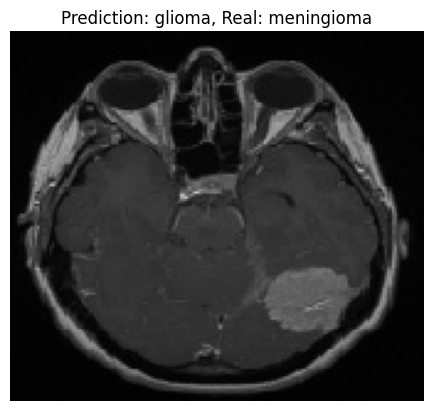

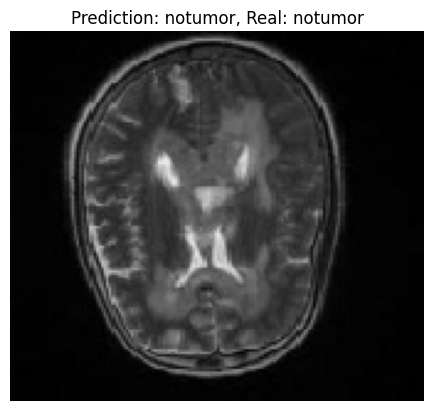

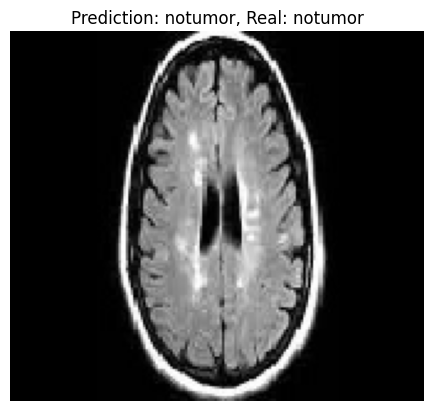

In [ ]:
# Make 10 predictions with the testing data
predictions = model.predict(test_images[:10])

class_names = list(train_data.class_indices.keys())

for i in range(10):
    predicted_label = np.argmax(predictions[i])
    actual_label = test_labels[i]

    # Display the image
    plt.imshow(test_images[i])
    plt.title(f"Prediction: {class_names[predicted_label]}, Real: {class_names[actual_label]}")
    plt.axis('off')
    plt.show()